In [1]:
!nvidia-smi

Fri May 14 20:34:49 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   67C    P8    11W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
!pip install -U git+https://github.com/albu/albumentations --no-cache-dir

  Cloning https://github.com/albu/albumentations to /tmp/pip-req-build-k2g5jaj0
  Running command git clone -q https://github.com/albu/albumentations /tmp/pip-req-build-k2g5jaj0
  Created wheel for albumentations: filename=albumentations-0.5.2-cp37-none-any.whl size=93260 sha256=777a5c8b1184666ee044dfe4c37b5f86c0a32424c82006e8026e45ff46d1814d
  Stored in directory: /tmp/pip-ephem-wheel-cache-7jw033kt/wheels/45/8b/e4/2837bbcf517d00732b8e394f8646f22b8723ac00993230188b
Successfully built albumentations
  Found existing installation: albumentations 0.5.2
    Uninstalling albumentations-0.5.2:
      Successfully uninstalled albumentations-0.5.2


In [3]:
!pip install -U catalyst

Requirement already up-to-date: catalyst in /usr/local/lib/python3.7/dist-packages (21.4.2)


In [4]:
!pip install spacecutter

In [5]:
import os
from typing import Optional, Tuple, Callable

import torch
import torchvision
torchvision.set_image_backend('accimage')
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import albumentations as A
from albumentations.pytorch import ToTensorV2

import cv2
from google.colab.patches import cv2_imshow

import catalyst
from catalyst import dl, utils

from tqdm.notebook import tqdm
import pandas as pd

from spacecutter.models import OrdinalLogisticModel, LogisticCumulativeLink
from spacecutter.losses import CumulativeLinkLoss
# from spacecutter.callbacks import AscensionCallback

from matplotlib import colors, pyplot as plt
%matplotlib inline

In [6]:
assert A.__version__ == '0.5.2'

In [7]:
import numpy as np
np.random.seed(123)
import random
random.seed(123)
torch.backends.cudnn.deterministic = True
torch.manual_seed(123)
torch.cuda.manual_seed(123)

In [8]:
from google.colab import drive
drive.mount('/content/gdrive/')

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


In [9]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [10]:
class TCCDataset(Dataset):
    def __init__(self,
                 image_paths: np.array,
                 masks_paths: np.array,
                 labels: np.array = None,
                 mode: str = 'train'):
        self.image_paths = image_paths
        self.masks_paths = masks_paths
        self.labels = labels
        assert mode in ['train', 'valid', 'test'], "wrong mode, should be 'train', 'valid' or 'test"
        self.mode = mode
        self.to_tensor_transform = torchvision.transforms.ToTensor()
        # maybe grayscale is better?
        self.train_transforms = A.Compose([
            A.Rotate(limit=180, border_mode=cv2.BORDER_CONSTANT, value=0),
            A.HorizontalFlip(),
            A.VerticalFlip(),
            A.ColorJitter(0.3, 0.3, 0.3, 0),
            A.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
            A.pytorch.ToTensorV2() 
        ])
        self.valid_transforms = A.Compose([                                           
            A.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
            A.pytorch.ToTensorV2()  
        ])

    def __len__(self) -> int:
        return self.labels.shape[0]

    def load_sample(self, file: str) -> np.array:
        image = cv2.imread(file)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        return image

    def _prepare_sample(self, image: np.array, mask: np.array) -> np.array:
        # image = cv2.resize(image, dsize=(self.rescale_size, self.rescale_size))
        # mask = cv2.resize(mask, dsize=(self.rescale_size, self.rescale_size))
        mask_norm =  np.max(mask)
        if mask_norm > 1:
            return (image * (mask / mask_norm)).astype('uint8')
        else:
            return (image * mask).astype('uint8')

    def __getitem__(self, item: int) -> Tuple[torch.Tensor, torch.Tensor] or torch.Tensor:
        img = self.load_sample(self.image_paths[item])
        mask = self.load_sample(self.masks_paths[item])
        X = self._prepare_sample(img, mask)

        if self.mode == 'train':
            # X = self.train_transforms(image=X)
            # return X['image'].to(device), torch.tensor(self.labels[item][...,None]).to(device)
            return self.to_tensor_transform(X).to(device), torch.tensor(self.labels[item][...,None]).to(device)

        elif self.mode == 'valid':
            # X = self.valid_transforms(image=X)
            return self.to_tensor_transform(X).to(device), torch.tensor(self.labels[item][...,None]).to(device)

        else:
            # X = self.valid_transforms(X)
            # return X.to(device)
            return self.to_tensor_transform(X).to(device)
        

In [11]:
%%time
from google_drive_downloader import GoogleDriveDownloader as gdd
gdd.download_file_from_google_drive(file_id='11oC2uZ_BTHYMFzVmxjbA9T-c-HYAWBZr' , 
                                    dest_path='/content/resized_data/resized_data.zip', 
                                    unzip=True)

CPU times: user 1.98 ms, sys: 0 ns, total: 1.98 ms
Wall time: 1.71 ms


In [12]:
data_df = pd.read_csv('/content/gdrive/MyDrive/Deep_Learning/technotrek_spring_2021/homework_5/index_upd.csv')

In [13]:
data_df['full_filename'] = data_df['full_filename'].apply(lambda x: x.replace('\\', '/'))
data_df['mask_fname'] = data_df['mask_fname'].apply(lambda x: './data/' + x)
data_df['resized_full_filename'] = data_df['full_filename'].apply(lambda x: x.replace('./data', './resized_data'))
data_df['resized_mask_fname'] = data_df['mask_fname'].apply(lambda x: x.replace('./data', './resized_data'))

In [14]:
# % cd gdrive/MyDrive/Deep_Learning/technotrek_spring_2021/homework_5

In [15]:
# % ls

Sampling balanced vaild data

In [16]:
TRAIN_VAL_SPLIT = 0.15

In [17]:
num_classes = data_df['observed_TCC'].unique().shape[0]

In [18]:
data_classes = []
for class_i in range(num_classes):
    data_classes.append(data_df[data_df['observed_TCC'] == class_i])

In [19]:
num_valid_per_class = int(data_df.shape[0] * TRAIN_VAL_SPLIT // num_classes)

In [20]:
class_lengths = [len(s) for s in data_classes]
class_random_indexes = [np.random.choice(lenght, size=lenght, replace=False) for lenght in class_lengths]

In [21]:
valid_data = [class_data.iloc[indxs[:num_valid_per_class]] for class_data, indxs in zip(data_classes, class_random_indexes)]
train_data = [class_data.iloc[indxs[num_valid_per_class:]] for class_data, indxs in zip(data_classes, class_random_indexes)]

In [22]:
valid_data = pd.concat(valid_data, axis = 0).reset_index()
train_data = pd.concat(train_data, axis = 0).reset_index()

In [23]:
image_paths_train = train_data['resized_full_filename']
masks_paths_train = train_data['resized_mask_fname']
y_train = train_data['observed_TCC']
image_paths_valid = valid_data['resized_full_filename']
masks_paths_valid = valid_data['resized_mask_fname']
y_valid = valid_data['observed_TCC']

In [24]:
train_dataset = TCCDataset(image_paths_train, masks_paths_train, y_train, mode='train')
valid_dataset = TCCDataset(image_paths_valid, masks_paths_valid, y_valid, mode='valid')

In [25]:
BATCH_SIZE = 73 # Change me!!!!

In [26]:
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=False, drop_last=False)

In [27]:
def imshow(inp, title=None, plt_ax=plt, default=False):
    """Imshow для тензоров"""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    # print(inp)
    plt_ax.imshow(inp)
    if title is not None:
        plt_ax.set_title(title)
    plt_ax.grid(False)

In [28]:
# img, label = train_dataset[555]
# print(label)
# imshow(img.cpu())

In [29]:
from copy import deepcopy
from torch import nn

class LogisticCumulativeLink(nn.Module):
    """
    Converts a single number to the proportional odds of belonging to a class.
    Parameters
    ----------
    num_classes : int
        Number of ordered classes to partition the odds into.
    init_cutpoints : str (default='ordered')
        How to initialize the cutpoints of the model. Valid values are
        - ordered : cutpoints are initialized to halfway between each class.
        - random : cutpoints are initialized with random values.
    """

    def __init__(self, num_classes: int,
                 init_cutpoints: str = 'ordered') -> None:
        assert num_classes > 2, (
            'Only use this model if you have 3 or more classes'
        )
        super().__init__()
        self.num_classes = num_classes
        self.init_cutpoints = init_cutpoints
        if init_cutpoints == 'ordered':
            num_cutpoints = self.num_classes - 1
            cutpoints = torch.arange(num_cutpoints).float() - num_cutpoints / 2
            self.cutpoints = nn.Parameter(cutpoints)
        elif init_cutpoints == 'random':
            cutpoints = torch.rand(self.num_classes - 1).sort()[0]
            self.cutpoints = nn.Parameter(cutpoints)
        else:
            raise ValueError(f'{init_cutpoints} is not a valid init_cutpoints '
                             f'type')

    def forward(self, X: torch.Tensor) -> torch.Tensor:
        """
        Equation (11) from
        "On the consistency of ordinal regression methods", Pedregosa et. al.
        """
        sigmoids = torch.sigmoid(self.cutpoints - X)
        link_mat = sigmoids[:, 1:] - sigmoids[:, :-1]
        link_mat = torch.cat((
                sigmoids[:, [0]],
                link_mat,
                (1 - sigmoids[:, [-1]])
            ),
            dim=1
        )
        return link_mat


class OrdinalLogisticModel(nn.Module):
    """
    "Wrapper" model for outputting proportional odds of ordinal classes.
    Pass in any model that outputs a single prediction value, and this module
    will then pass that model through the LogisticCumulativeLink module.
    Parameters
    ----------
    predictor : nn.Module
        When called, must return a torch.FloatTensor with shape [batch_size, 1]
    init_cutpoints : str (default='ordered')
        How to initialize the cutpoints of the model. Valid values are
        - ordered : cutpoints are initialized to halfway between each class.
        - random : cutpoints are initialized with random values.
    """

    def __init__(self, predictor: nn.Module, num_classes: int,
                 init_cutpoints: str = 'ordered') -> None:
        super().__init__()
        self.num_classes = num_classes
        self.predictor = deepcopy(predictor)
        self.train_transforms = nn.Sequential(
            torchvision.transforms.RandomAffine(degrees=180, scale=(1.1, 1.1)),
            torchvision.transforms.RandomHorizontalFlip(),
            torchvision.transforms.RandomVerticalFlip(),
            torchvision.transforms.ColorJitter(0.3, 0.3, 0.3, 0),
            torchvision.transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) 
        )
        self.valid_transforms = nn.Sequential(
            torchvision.transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) 
        )
        self.link = LogisticCumulativeLink(self.num_classes,
                                           init_cutpoints=init_cutpoints)

    def forward(self, X: torch.Tensor) -> torch.Tensor:
        if self.training:
            return self.link(self.predictor(self.train_transforms(X)))
        else:
            return self.link(self.predictor(self.valid_transforms(X)))

In [30]:
predictor = torchvision.models.resnet152(pretrained=True)
# num_features -- это размерность вектора фич, поступающего на вход FC-слою
num_features = 2048
num_classes = 9
# Заменяем Fully-Connected слой на наш линейный классификатор
predictor.fc = nn.Linear(num_features, 1)

TCCModel = OrdinalLogisticModel(predictor, num_classes).to(device)

In [31]:
# the optimizer
optimizer = torch.optim.Adam(TCCModel.parameters(), lr=1e-3)

# the loss
from sklearn.utils.class_weight import compute_class_weight
criterion = CumulativeLinkLoss(class_weights=torch.tensor(compute_class_weight(class_weight='balanced', classes=np.unique(data_df['observed_TCC']), y=data_df['observed_TCC'])))

# loaders
loaders = {"train": train_loader, "valid": valid_loader}

In [32]:
from catalyst.core.callback import Callback

class MyAscensionCallCallback(Callback):
    """
    Ensure that each cutpoint is ordered in ascending value.
    e.g.
    .. < cutpoint[i - 1] < cutpoint[i] < cutpoint[i + 1] < ...
    This is done by clipping the cutpoint values at the end of a batch gradient
    update. By no means is this an efficient way to do things, but it works out
    of the box with stochastic gradient descent.
    Parameters
    ----------
    margin : float, (default=0.0)
        The minimum value between any two adjacent cutpoints.
        e.g. enforce that cutpoint[i - 1] + margin < cutpoint[i]
    min_val : float, (default=-1e6)
        Minimum value that the smallest cutpoint may take.
    """
    def __init__(self, margin: float = 0.0, min_val: float = -1.0e6) -> None:
        super().__init__(order=100)
        self.margin = margin
        self.min_val = min_val

    def clip(self, module: nn.Module) -> None:
        # We assume the cutpoints parameters are called `cutpoints`.
        if isinstance(module, LogisticCumulativeLink):
            cutpoints = module.cutpoints.data
            for i in range(cutpoints.shape[0] - 1):
                cutpoints[i].clamp_(self.min_val,
                                    cutpoints[i + 1] - self.margin)

    def on_batch_end(self, runner: nn.Module, *args, **kwargs) -> None:
        runner.get_model('train').link.apply(self.clip)

In [34]:
class MySavingCallCallback(Callback):
    def __init__(self) -> None:
        super().__init__(order=110)
    
    def on_epoch_end(self, runner: nn.Module, *args, **kwargs) -> None:
        torch.save(runner.get_model('train').state_dict(), '/content/gdrive/MyDrive/Deep_Learning/technotrek_spring_2021/homework_5/model_checkpoints/run003.pth')

In [35]:
# runner          
runner = dl.SupervisedRunner(
            input_key="features", 
            output_key="logits", 
            target_key="targets", 
            loss_key="loss"
)

In [ ]:
# runner.get_model('train')

In [36]:
runner.train(
    loaders=loaders,
    model=TCCModel, criterion=criterion, optimizer=optimizer,
    num_epochs=5,
    callbacks=[dl.AccuracyCallback(input_key="logits", target_key="targets"),
               MyAscensionCallCallback(),
               MySavingCallCallback()],
    valid_loader="valid",
    valid_metric="loss",
    minimize_valid_metric=True,
    verbose=True,
    load_best_on_end=True,
)   

/usr/local/lib/python3.7/dist-packages/catalyst/core/runner.py:717: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  for k, v in self.batch_metrics.items()



train (1/5) accuracy: 0.5960700511932373 | accuracy/std: 0.07535953763982518 | accuracy01: 0.5960700511932373 | accuracy01/std: 0.07535953763982518 | loss: 1.3004482984542847 | loss/mean: 1.3004482984542847 | loss/std: 0.20074958689113523 | lr: 0.001 | momentum: 0.9



valid (1/5) accuracy: 0.3694770336151123 | accuracy/std: 0.30308812785446054 | accuracy01: 0.3694770336151123 | accuracy01/std: 0.30308812785446054 | loss: 2.3035621643066406 | loss/mean: 2.3035621643066406 | loss/std: 1.3078110160627519 | lr: 0.001 | momentum: 0.9
* Epoch (1/5) 



train (2/5) accuracy: 0.632430911064148 | accuracy/std: 0.05949887490662421 | accuracy01: 0.632430911064148 | accuracy01/std: 0.05949887490662421 | loss: 1.1852022409439087 | loss/mean: 1.1852022409439087 | loss/std: 0.1493219820304824 | lr: 0.001 | momentum: 0.9



valid (2/5) accuracy: 0.5070258975028992 | accuracy/std: 0.22263418369524834 | accuracy01: 0.5070258975028992 | accuracy01/std: 0.22263418369524834 | loss: 1.9082987308502197 | loss/mean: 1.9082987308502197 | loss/std: 1.080387540948835 | lr: 0.001 | momentum: 0.9
* Epoch (2/5) 


Keyboard Interrupt



KeyboardInterrupt: ignored

In [ ]:
torch.save(TCCModel.state_dict(), '/content/gdrive/MyDrive/Deep_Learning/technotrek_spring_2021/homework_5/model_checkpoints/run001.pth')

In [43]:
TCCModel.load_state_dict(torch.load('/content/gdrive/MyDrive/Deep_Learning/technotrek_spring_2021/homework_5/model_checkpoints/run003.pth'))

<All keys matched successfully>

In [44]:
num_true = 0
TCCModel.eval()
with torch.no_grad():
    for X, y in tqdm(loaders['valid']):
        num_true += sum(torch.argmax(TCCModel(X), axis=-1) == y.squeeze(-1))

In [45]:
num_true

tensor(7000, device='cuda:0')

In [47]:
num_true / (len(loaders['valid'])*BATCH_SIZE)

tensor(0.5047, device='cuda:0')

In [51]:
len(loaders['valid'])

1381

In [52]:
preds = TCCModel(X)

In [53]:
torch.argmax(preds, axis=-1)

tensor([3, 4, 3, 6, 7, 8, 4, 4, 6, 7], device='cuda:0')

In [62]:
y.squeeze(-1)

tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0')

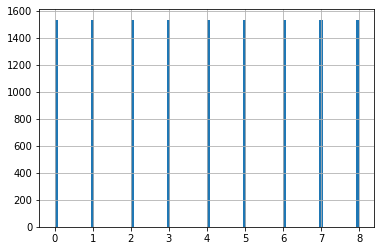

In [58]:
y_valid.hist(bins=100)